<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

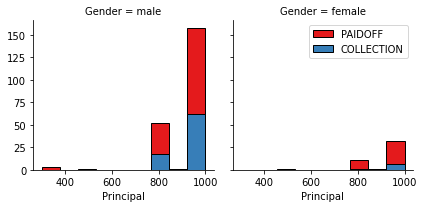

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

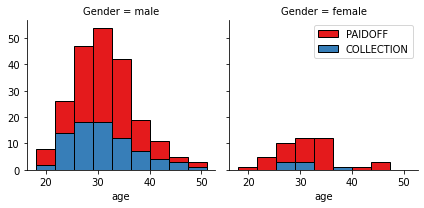

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

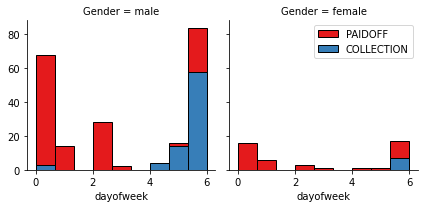

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

# !!!! please read my annotations carefully to understand my solution , I followed exactly the guidness and the modelling process is axactly as required !!!!

## if you think there is something missing please write a coment (not just refuse it)


# finding the best k:
first I find the best k by applying the KNN  algorithm on the training dataset.
to find the best k we may use a loop and then compute the highest accuracy (as has been done in the course) but I used GridSearch which calculates the best k and other parametrs automatically

In [20]:
# Import libs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to find the best hyperparameter combination K and weights
model = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':range(1,11), 'weights':('uniform', 'distance')}, cv=5, return_train_score = False)
# here applying model on the train set for al values of k
model.fit(X, y)
pd_model = pd.DataFrame(model.cv_results_)
pd_model[["param_n_neighbors", "param_weights", "mean_test_score", "rank_test_score"]].set_index("rank_test_score").sort_values("rank_test_score")

,param_n_neighbors,param_weights,mean_test_score
rank_test_score,,,
1,7,uniform,0.722650
2,5,uniform,0.719917
3,6,uniform,0.699710
4,3,uniform,0.699669
5,5,distance,0.694203
6,4,uniform,0.691139
7,6,distance,0.688364
8,8,distance,0.688364
9,3,distance,0.685466


## we see that the best accuracy in the first row k=6, and the weights is uniform
## now we create our knn model using these parametrs, and aply it on the training dataset (X,y)

In [21]:
# modeling with KNN
k = 7
weights = "uniform"
neigh7 = KNeighborsClassifier(n_neighbors = k, weights = weights).fit(X, y)

## please notice that the preprocessing of the test data, and prediction, evaluation and report are found later in the evaluation part

# Decision Tree

# even though finding the best parametrs (such as max-depth) are not required in decision tree, I calculated them in the same way as in KNN and then I created the model

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to find the best hyperparameter combination
model = GridSearchCV(DecisionTreeClassifier(), {'criterion':('entropy', 'gini'), 'max_depth':range(1,11)}, cv=5, return_train_score = False)
model.fit(X, y)
pd_model = pd.DataFrame(model.cv_results_)
pd_model[["param_criterion", "param_max_depth", "mean_test_score", "rank_test_score"]].set_index("rank_test_score").sort_values("rank_test_score")

,param_criterion,param_max_depth,mean_test_score
rank_test_score,,,
1,entropy,1,0.751470
1,gini,1,0.751470
3,entropy,10,0.694079
4,gini,9,0.688199
5,entropy,9,0.650435
6,gini,10,0.647743
7,gini,7,0.636108
8,entropy,7,0.633251
9,gini,6,0.630393


# here is the modeling with decision tree using the computed parametrs
best max_depth=1 (not 4 as in the course)

In [53]:
criterion = "entropy"
max_depth = 1
#create the model
loanTree = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)
# apply the model on the training data
loanTree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=1)

[Text(125.55000000000001, 195.696, 'X[4] <= -0.188\nentropy = 0.809\nsamples = 346\nvalue = [86, 260]'),
 Text(55.800000000000004, 152.208, 'X[7] <= 0.14\nentropy = 0.149\nsamples = 141\nvalue = [3, 138]'),
 Text(27.900000000000002, 108.72, 'entropy = 0.0\nsamples = 84\nvalue = [0, 84]'),
 Text(83.7, 108.72, 'X[3] <= 0.979\nentropy = 0.297\nsamples = 57\nvalue = [3, 54]'),
 Text(55.800000000000004, 65.232, 'X[2] <= -0.902\nentropy = 0.342\nsamples = 47\nvalue = [3, 44]'),
 Text(27.900000000000002, 21.744, 'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(83.7, 21.744, 'entropy = 0.384\nsamples = 40\nvalue = [3, 37]'),
 Text(111.60000000000001, 65.232, 'entropy = 0.0\nsamples = 10\nvalue = [0, 10]'),
 Text(195.3, 152.208, 'X[1] <= -1.46\nentropy = 0.974\nsamples = 205\nvalue = [83, 122]'),
 Text(167.4, 108.72, 'entropy = 0.0\nsamples = 7\nvalue = [0, 7]'),
 Text(223.20000000000002, 108.72, 'X[3] <= 0.979\nentropy = 0.981\nsamples = 198\nvalue = [83, 115]'),
 Text(167.4, 65.232, 'X[7]

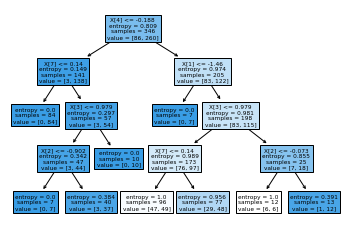

In [46]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure()
tree.plot_tree(loanTree, filled = True)

In [25]:
import sklearn
sklearn.show_versions()



System:
    python: 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\BASEM\anaconda3\envs\dvis\python.exe
   machine: Windows-10-10.0.17134-SP0

Python dependencies:
          pip: 20.1.1
   setuptools: 47.3.1.post20200622
      sklearn: 0.23.1
        numpy: 1.19.0
        scipy: 1.5.0
       Cython: None
       pandas: 1.0.5
   matplotlib: 3.2.2
       joblib: 0.15.1
threadpoolctl: 2.1.0

Built with OpenMP: True


## just for more details I printed out the resulted tree
## the prediction and evaluation later

In [ ]:
# Install the python package/library pydotplus via conda
!conda install -c conda-forge pydotplus -y

In [ ]:
# visualize the loanTree trained with best hyperparameters
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(loanTree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Indeed a coarse model

# Support Vector Machine

## again I search for the best parametrs of svm before create and apply the model

In [26]:
# Import libs
from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to find the best hyperparameter combination
model = GridSearchCV(svm.SVC(gamma = 'auto'), {
    'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
    'C':(0.001,0.01,1,100,1000)}, 
    cv=5, return_train_score = False)
model.fit(X, y)
pd_model = pd.DataFrame(model.cv_results_)
pd_model[["param_kernel", "param_C", "mean_test_score", "rank_test_score"]].set_index("rank_test_score").sort_values("rank_test_score")

,param_kernel,param_C,mean_test_score
rank_test_score,,,
1,linear,0.001,0.751470
1,poly,0.001,0.751470
1,rbf,0.001,0.751470
1,sigmoid,0.001,0.751470
1,linear,0.01,0.751470
1,poly,0.01,0.751470
1,rbf,0.01,0.751470
1,sigmoid,0.01,0.751470
9,poly,1,0.734120


## modeling with SVM

In [50]:
# use the best parameters found through grid search and fit the model with all the data
kernel='rbf'
C = 0.01
clf = svm.SVC(kernel = kernel,C = C,probability=True)
clf.fit(X, y) 

SVC(C=0.01, probability=True)

# Logistic Regression

## again we search for the best params and then modeling 

## the evaluation and prediction are later

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Use GridSearchCV to find the best hyperparameter combination
model = GridSearchCV(LogisticRegression(max_iter = 10000), {
    'C':(0.001,0.01,1,100,1000), 
    'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}, 
    cv=5, return_train_score = False)
model.fit(X, y)
pd_model = pd.DataFrame(model.cv_results_)
pd_model[["param_C", "param_solver", "mean_test_score", "rank_test_score"]].set_index("rank_test_score").sort_values("rank_test_score")

,param_C,param_solver,mean_test_score
rank_test_score,,,
1,0.001,newton-cg,0.751470
1,0.001,lbfgs,0.751470
1,0.001,sag,0.751470
1,0.001,saga,0.751470
1,0.01,newton-cg,0.751470
1,0.01,lbfgs,0.751470
1,0.01,sag,0.751470
1,0.01,saga,0.751470
9,1,saga,0.685093


## modeling with logistic Regression

In [54]:
C2 = 0.01
solver = 'lbfgs'
LR = LogisticRegression(C = C2, solver = solver)
LR.fit(X, y)

LogisticRegression(C=0.01)

# Model Evaluation using Test set

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

### Load Test set for evaluation 

In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


# now pre-proccesing the test data and featute extraction as done on the training dataset above, then the train and test data will be matched

In [32]:
# convert to date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# add weekend column
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# convert categorical gender to numerical values 0,1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# select the numerical varuables
testFeature = test_df[['Principal','terms','age','Gender','weekend']]

# add dummies for the values of education variable, and drope the column master or above
testFeature = pd.concat([testFeature,pd.get_dummies(test_df['education'])], axis=1)
testFeature.drop(['Master or Above'], axis = 1,inplace=True)

# create the test data Xtest which we will use for prediction and evaluation
Xtest = testFeature
# normalize Xtest
Xtest = preprocessing.StandardScaler().fit(Xtest).transform(Xtest)

# craete the label of test data to compare to the prediction result in the evaluation process
ytest = test_df['loan_status'].values

In [41]:
ytest

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION'], dtype=object)

# prediction and evaluation using KNN
## we apply the built KNN model on Xtest and compute the required metrics

In [37]:
# prediction
yhat_knn = neigh7.predict(Xtest)

# evaluation
#jaccard_knn = jaccard_similarity_score(ytest, yhat_knn)
f1_knn = f1_score(ytest, yhat_knn, average='weighted', labels= yhat_knn)

print('pred_knn=  ' + str(yhat_knn))
print(f1_knn)

pred_knn=  ['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION'
 'PAIDOFF']
0.7924086335062266


# prediction and evaluation using Decision tree

In [47]:
# prediction

loantree = loanTree.predict(Xtest)

# evaluation
#jaccard_tree = jaccard_similarity_score(ytest, loantree)
f1_tree = f1_score(ytest, loantree, average='weighted', labels= loantree)

print(loantree)
print(f1_tree)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
0.8521400778210121


# prediction and evaluation SVM

In [49]:
#predict
yhat_SVM =clf.predict(Xtest)

# evaluation
#jaccard_svm = jaccard_similarity_score(ytest, yhat_SVM)
f1_svm = f1_score(ytest, yhat_SVM, average='weighted', labels= yhat_SVM)

print(yhat_SVM)
print(f1_svm)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
0.8332073646340357


# prediction and evaluation logistic regression

In [52]:
# predict yhat and the probabilities
yhat_logreg =LR.predict(Xtest)
y_prob = LR.predict_proba(Xtest)

# evaluation
# evaluation
#jaccard_logreg = jaccard_similarity_score(ytest, yhat_logreg)
f1_logreg = f1_score(ytest, yhat_logreg, average='weighted', labels= yhat_logreg)
logloss = log_loss(ytest,y_prob)

#print(jaccard_logreg)
print(yhat_logreg)
print(f1_logreg)
print(logloss)

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
0.8510638297872339
0.5566084946309205


# print out the report for all evaluation metrics

In [ ]:
report ={'algorithm':['KNN', 'Decision tree', 'SVM', 'logisticReg'],
             'Jaccard':[jaccard_knn, jaccard_tree, jaccard_svm, jaccard_logreg],
        'F1_score' : [f1_knn, f1_tree, f1_svm, f1_logreg ],
         'LogLoss' : ['NA', 'NA', 'NA', log_loss(y_test,yhat_prob)]
        
        }

rep_df=pd.DataFrame(report)
rep_df

In [ ]:
#######################################################

In [ ]:
# see the actural test label and the predicted labels
pd_result = pd.DataFrame({'ytest':ytest, 'neigh7':neigh7.predict(Xtest), 'loanTree':loanTree.predict(Xtest), 'clf':clf.predict(Xtest), 'LR':LR.predict(Xtest)})
pd_result


In [ ]:
# the accuracy scores
print ('KNN:')
print('f1_score: ', f1_score(ytest, neigh7.predict(Xtest), average='weighted', labels=np.unique(neigh7.predict(Xtest))))
print('jaccard_similarity_score: ', jaccard_similarity_score(ytest, neigh7.predict(Xtest)))
print('log_loss: ', log_loss(ytest, neigh7.predict_proba(Xtest)))

print('-----------------------------------------------------')
print ('Decision Tree:')
print('f1_score: ', f1_score(ytest, loanTree.predict(Xtest), average='weighted', labels=np.unique(loanTree.predict(Xtest))))
print('jaccard_similarity_score: ', jaccard_similarity_score(ytest, loanTree.predict(Xtest)))
print('log_loss: ', log_loss(ytest, loanTree.predict_proba(Xtest)))

print('-----------------------------------------------------')
print ('SVM:')
print('f1_score: ', f1_score(ytest, clf.predict(Xtest), average='weighted', labels=np.unique(clf.predict(Xtest))))
print('jaccard_similarity_score: ', jaccard_similarity_score(ytest, clf.predict(Xtest)))
print('log_loss: ', log_loss(ytest, clf.predict_proba(Xtest)))

print('-----------------------------------------------------')
print ('LR:')
print('f1_score: ', f1_score(ytest, LR.predict(Xtest), average='weighted', labels=np.unique(LR.predict(Xtest))))
print('jaccard_similarity_score: ', jaccard_similarity_score(ytest, LR.predict(Xtest)))
print('log_loss: ', log_loss(ytest, LR.predict_proba(Xtest)))

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>